In [1]:
import torch
import numpy as np
import uncertainty_toolbox as uct
import uncertainty_toolbox.metrics as umetrics
from uncertainty_toolbox.metrics_calibration import (
    get_proportion_lists_vectorized,
)
import uncertainty_toolbox.viz as uviz
from uncertainty_toolbox.recalibration import iso_recal

from data import data_preprocess
from evaluation import metrics
from model import concrete_dropout, deep_ensemble, subnetwork

In [2]:
x_train, y_train, x_test, y_test = data_preprocess.data_preprocess('kin8nm')

In [3]:
deep_ensemble_model = deep_ensemble.train_model(x_train, y_train, n_epoch = 500, hidden_layers = [100, 100, 100], learning_rate = 0.001, exp_decay = .995)

initial loss:  0.3301526606082916
final loss:  -4.112091541290283
initial loss:  0.3619704842567444
final loss:  -4.095345973968506
initial loss:  0.561269998550415
final loss:  -3.9959487915039062
initial loss:  0.7571827173233032
final loss:  -3.8981704711914062
initial loss:  0.6104811429977417
final loss:  -4.028102397918701


Deep ensemble test MAPE:  0.12698194
Deep ensemble test RMSE:  0.08741547
Deep ensemble test NLLK:  -3.9186382
Deep ensemble test CRPS:  tensor(0.0479)


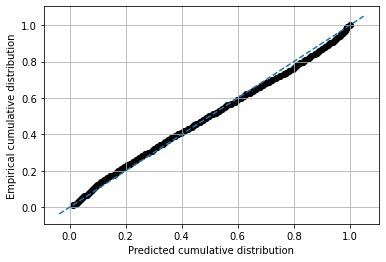

Deep ensemble test calibration error when step size is 0.001:  0.43928056805676885
Deep ensemble test calibration error when step size is 0.01:  0.04361849200633201
Deep ensemble test calibration error when step size is 0.1:  0.0040838448574008574


In [4]:
mean_pred, var_pred = deep_ensemble_model(x_test)
mean_pred = mean_pred.detach().numpy()
var_pred = var_pred.detach().numpy()
sd_pred = np.sqrt(var_pred)

print('Deep ensemble test MAPE: ', metrics.mape(y_test.detach().numpy(), mean_pred))
print('Deep ensemble test RMSE: ', metrics.rmse(y_test.detach().numpy(), mean_pred))
print('Deep ensemble test NLLK: ', metrics.nllk(y_test.detach().numpy(), mean_pred, var_pred))
print('Deep ensemble test CRPS: ', metrics.CRPSMetric(x = y_test.squeeze(dim = 1), loc = torch.tensor(mean_pred).squeeze(dim = 1), scale = torch.tensor(sd_pred).squeeze(dim = 1)).gaussian_crps().mean())

pcdf = metrics.pcdf(mean_pred.squeeze(1), var_pred.squeeze(1), y_test.detach().numpy().squeeze(1))
metrics.draw_pcdf(pcdf)
print('Deep ensemble test calibration error when step size is 0.001: ', metrics.calibration_error(pcdf, step = 0.001))
print('Deep ensemble test calibration error when step size is 0.01: ', metrics.calibration_error(pcdf, step = 0.01))
print('Deep ensemble test calibration error when step size is 0.1: ', metrics.calibration_error(pcdf, step = 0.1))

In [5]:
print(uct.metrics.get_all_metrics(mean_pred.squeeze(1), sd_pred.squeeze(1), y_test.detach().numpy().squeeze(1)))

 (1/n) Calculating accuracy metrics
 (2/n) Calculating average calibration metrics


 20%|████████▌                                  | 2/10 [00:00<00:00, 10.96it/s]

 (3/n) Calculating adversarial group calibration metrics
  [1/2] for mean absolute calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


 20%|████████▌                                  | 2/10 [00:00<00:00, 10.91it/s]

  [2/2] for root mean squared calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████████████████████████████████████| 10/10 [00:01<00:00,  8.10it/s]


 (4/n) Calculating sharpness metrics
 (n/n) Calculating proper scoring rule metrics
**Finished Calculating All Metrics**


===================== Accuracy Metrics =====================
  MAE           0.067
  RMSE          0.087
  MDAE          0.053
  MARPD         11.455
  R2            0.888
  Correlation   0.943
=============== Average Calibration Metrics ================
  Root-mean-squared Calibration Error   0.041
  Mean-absolute Calibration Error       0.036
  Miscalibration Area                   0.036
========== Adversarial Group Calibration Metrics ===========
  Mean-absolute Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.060
     Group Size: 0.56 -- Calibration Error: 0.043
     Group Size: 1.00 -- Calibration Error: 0.036
  Root-mean-squared Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.067
     Group Size: 0.56 -- Calibration Error: 0.051
     Group Size: 1.00 -- Calibration Error: 0.041
===============

Lims is None. Setting lims now:
min_max_true: (0.06322076, 1.4585207)
min_max_pred: (0.22779468, 1.4459565)
lims: (0.06322076, 1.4585207)
lims_ext: (-0.07630922943353655, 1.5980506420135498)


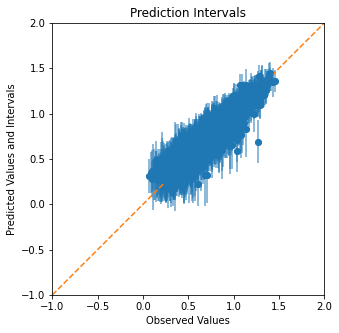

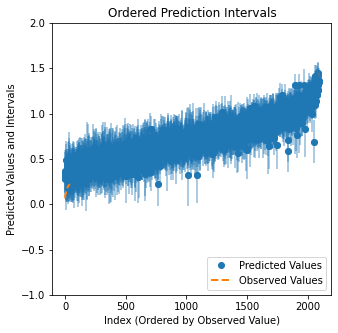

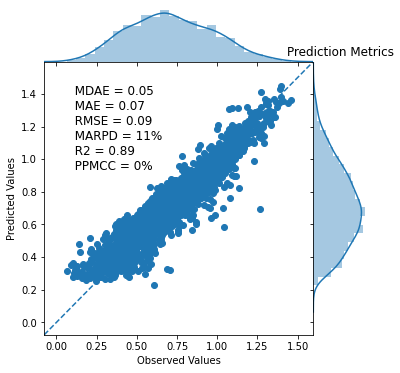

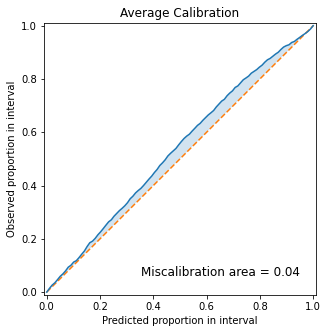

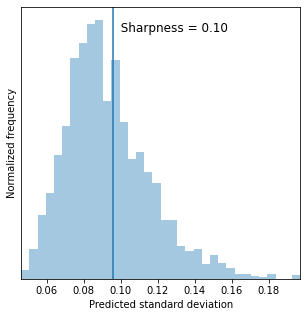

In [6]:
y = y_test.detach().numpy().squeeze(1)

uviz.plot_intervals(mean_pred.squeeze(1), sd_pred.squeeze(1), y)
uviz.plot_intervals_ordered(mean_pred.squeeze(1), sd_pred.squeeze(1), y)
uviz.plot_parity(mean_pred.squeeze(1), y)
uviz.plot_calibration(mean_pred.squeeze(1), sd_pred.squeeze(1), y)
uviz.plot_sharpness(sd_pred.squeeze(1))

In [7]:
concrete_dropout_model = concrete_dropout.train_model(x_train, y_train, n_epoch = 200, n_features = 200, learning_rate = 0.001)

final loss:  -5.572537899017334


Concrete dropout test MAPE:  0.120326586
Concrete dropout test RMSE:  0.08379673
Concrete dropout test NLLK:  -1.2950865
Concrete dropout test CRPS:  tensor(0.0505)


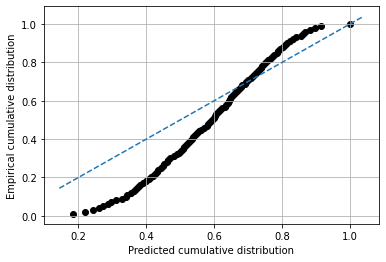

Concrete dropout test calibration error when step size is 0.001:  18.95807615828669
Concrete dropout test calibration error when step size is 0.01:  1.8897062468696186
Concrete dropout test calibration error when step size is 0.1:  0.1697250108763604


In [8]:
mean_pred, log_var_pred, _ = concrete_dropout_model(x_test)
mean_pred = mean_pred.detach().numpy()
var_pred = np.exp(log_var_pred.detach().numpy())
sd_pred = np.sqrt(var_pred)

print('Concrete dropout test MAPE: ', metrics.mape(y_test.detach().numpy(), mean_pred))
print('Concrete dropout test RMSE: ', metrics.rmse(y_test.detach().numpy(), mean_pred))
print('Concrete dropout test NLLK: ', metrics.nllk(y_test.detach().numpy(), mean_pred, var_pred))
print('Concrete dropout test CRPS: ', metrics.CRPSMetric(x = y_test.squeeze(dim = 1), loc = torch.tensor(mean_pred).squeeze(dim = 1), scale = torch.tensor(sd_pred).squeeze(dim = 1)).gaussian_crps().mean())

pcdf = metrics.pcdf(mean_pred.squeeze(1), var_pred.squeeze(1), y_test.detach().numpy().squeeze(1))
metrics.draw_pcdf(pcdf)
print('Concrete dropout test calibration error when step size is 0.001: ', metrics.calibration_error(pcdf, step = 0.001))
print('Concrete dropout test calibration error when step size is 0.01: ', metrics.calibration_error(pcdf, step = 0.01))
print('Concrete dropout test calibration error when step size is 0.1: ', metrics.calibration_error(pcdf, step = 0.1))

In [9]:
print(uct.metrics.get_all_metrics(mean_pred.squeeze(1), sd_pred.squeeze(1), y_test.detach().numpy().squeeze(1)))

 (1/n) Calculating accuracy metrics
 (2/n) Calculating average calibration metrics


 20%|████████▌                                  | 2/10 [00:00<00:00, 10.78it/s]

 (3/n) Calculating adversarial group calibration metrics
  [1/2] for mean absolute calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


 20%|████████▌                                  | 2/10 [00:00<00:00, 10.69it/s]

  [2/2] for root mean squared calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████████████████████████████████████| 10/10 [00:01<00:00,  8.00it/s]


 (4/n) Calculating sharpness metrics
 (n/n) Calculating proper scoring rule metrics
**Finished Calculating All Metrics**


===================== Accuracy Metrics =====================
  MAE           0.065
  RMSE          0.084
  MDAE          0.053
  MARPD         11.089
  R2            0.897
  Correlation   0.950
=============== Average Calibration Metrics ================
  Root-mean-squared Calibration Error   0.220
  Mean-absolute Calibration Error       0.195
  Miscalibration Area                   0.197
========== Adversarial Group Calibration Metrics ===========
  Mean-absolute Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.222
     Group Size: 0.56 -- Calibration Error: 0.205
     Group Size: 1.00 -- Calibration Error: 0.195
  Root-mean-squared Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.247
     Group Size: 0.56 -- Calibration Error: 0.231
     Group Size: 1.00 -- Calibration Error: 0.220
===============

Lims is None. Setting lims now:
min_max_true: (0.06322076, 1.4585207)
min_max_pred: (0.1438427, 1.5092182)
lims: (0.06322076, 1.5092182)
lims_ext: (-0.08137898594141008, 1.6538179636001586)


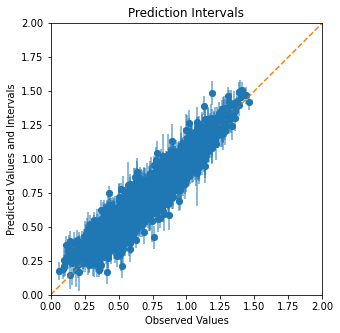

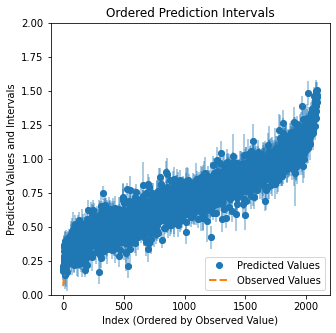

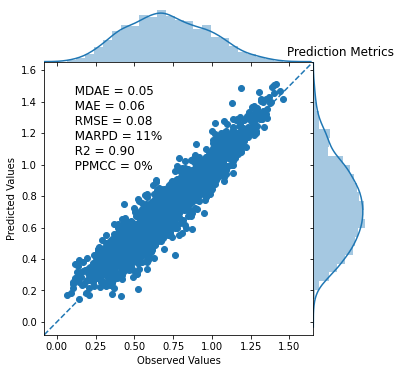

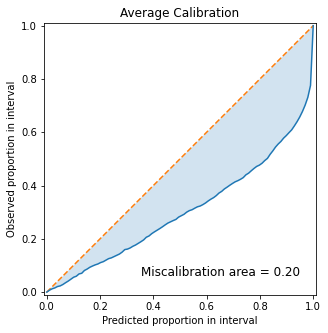

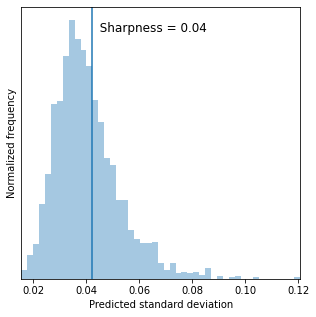

In [10]:
print(uct.metrics.get_all_metrics(mean_pred.squeeze(1), sd_pred.squeeze(1), y_test.detach().numpy().squeeze(1)))

In [48]:
subnetwork_model = subnetwork.train_model(x_train, y_train, n_epoch = 1000, hidden_layers = [100, 100, 100], learning_rate = 0.003, exp_decay = .997)

initial loss:  0.5502743124961853
final loss:  -3.4467132091522217


Subnetwork test MAPE:  0.15506442
Subnetwork test RMSE:  0.11111204
Subnetwork test NLLK:  -3.3646438
Subnetwork test CRPS:  tensor(0.0628)


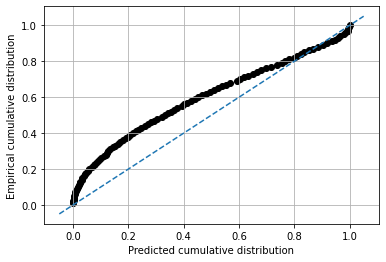

Subnetwork test calibration error when step size is 0.001:  15.094215357420968
Subnetwork test calibration error when step size is 0.01:  1.509974755875977
Subnetwork test calibration error when step size is 0.1:  0.15173674454993807


In [49]:
mean_pred, var_pred = subnetwork.test_model(subnetwork_model, x_test)
mean_pred = mean_pred.detach().numpy()
var_pred = var_pred.detach().numpy()
sd_pred = np.sqrt(var_pred)

print('Subnetwork test MAPE: ', metrics.mape(y_test.detach().numpy(), mean_pred))
print('Subnetwork test RMSE: ', metrics.rmse(y_test.detach().numpy(), mean_pred))
print('Subnetwork test NLLK: ', metrics.nllk(y_test.detach().numpy(), mean_pred, var_pred))
print('Subnetwork test CRPS: ', metrics.CRPSMetric(x = y_test.squeeze(dim = 1), loc = torch.tensor(mean_pred).squeeze(dim = 1), scale = torch.tensor(sd_pred).squeeze(dim = 1)).gaussian_crps().mean())

pcdf = metrics.pcdf(mean_pred.squeeze(1), var_pred.squeeze(1), y_test.detach().numpy().squeeze(1))
metrics.draw_pcdf(pcdf)
print('Subnetwork test calibration error when step size is 0.001: ', metrics.calibration_error(pcdf, step = 0.001))
print('Subnetwork test calibration error when step size is 0.01: ', metrics.calibration_error(pcdf, step = 0.01))
print('Subnetwork test calibration error when step size is 0.1: ', metrics.calibration_error(pcdf, step = 0.1))

In [50]:
print(uct.metrics.get_all_metrics(mean_pred.squeeze(1), sd_pred.squeeze(1), y_test.detach().numpy().squeeze(1)))

 (1/n) Calculating accuracy metrics
 (2/n) Calculating average calibration metrics


 20%|████████▌                                  | 2/10 [00:00<00:00, 10.87it/s]

 (3/n) Calculating adversarial group calibration metrics
  [1/2] for mean absolute calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


 20%|████████▌                                  | 2/10 [00:00<00:00, 10.72it/s]

  [2/2] for root mean squared calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████████████████████████████████████| 10/10 [00:01<00:00,  7.98it/s]


 (4/n) Calculating sharpness metrics
 (n/n) Calculating proper scoring rule metrics
**Finished Calculating All Metrics**


===================== Accuracy Metrics =====================
  MAE           0.089
  RMSE          0.111
  MDAE          0.077
  MARPD         14.465
  R2            0.819
  Correlation   0.925
=============== Average Calibration Metrics ================
  Root-mean-squared Calibration Error   0.074
  Mean-absolute Calibration Error       0.066
  Miscalibration Area                   0.066
========== Adversarial Group Calibration Metrics ===========
  Mean-absolute Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.093
     Group Size: 0.56 -- Calibration Error: 0.073
     Group Size: 1.00 -- Calibration Error: 0.066
  Root-mean-squared Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.098
     Group Size: 0.56 -- Calibration Error: 0.082
     Group Size: 1.00 -- Calibration Error: 0.074
===============

Lims is None. Setting lims now:
min_max_true: (0.06322076, 1.4585207)
min_max_pred: (0.33291402, 1.302708)
lims: (0.06322076, 1.4585207)
lims_ext: (-0.07630922943353655, 1.5980506420135498)


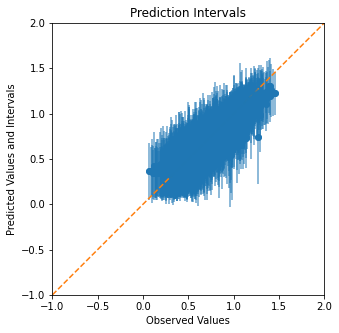

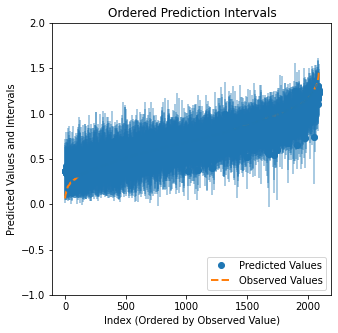

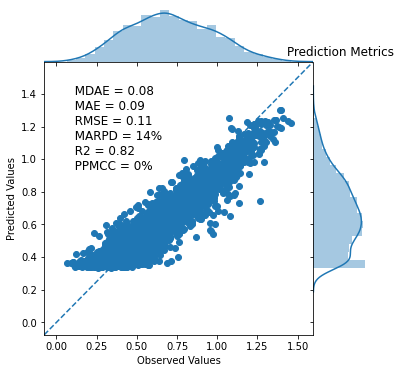

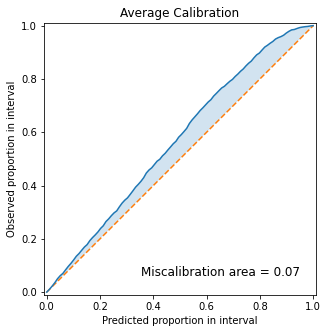

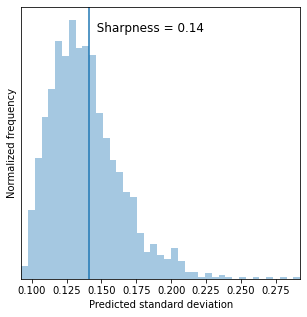

In [51]:
y = y_test.detach().numpy().squeeze(1)

uviz.plot_intervals(mean_pred.squeeze(1), sd_pred.squeeze(1), y)
uviz.plot_intervals_ordered(mean_pred.squeeze(1), sd_pred.squeeze(1), y)
uviz.plot_parity(mean_pred.squeeze(1), y)
uviz.plot_calibration(mean_pred.squeeze(1), sd_pred.squeeze(1), y)
uviz.plot_sharpness(sd_pred.squeeze(1))